In [1]:
%matplotlib inline

import copy
from datetime import date
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
import time
import torch as pt

sys.path.insert(0, '../..')

from function_space import DenseNet_tanh, DenseNet
from problems import ExponentialOnSphereNonlinearParabolic
from utilities import plot_moving_average, plot_loss_logs_extended, compute_test_error, do_importance_sampling, do_importance_sampling_Wei, plot_control_for_DoubleWell1d, plot_loss_logs, plot_solution, save_exp_logs, load_exp_logs
from solver import GeneralSolver

%load_ext autoreload
%autoreload 2

device = pt.device('cuda')

## Diffusion loss

In [2]:
d = 20
L = 160000
print_every = 1000
N = 25
delta_t = 0.001

seed = 42

problem = ExponentialOnSphereNonlinearParabolic(d=d, T=1.0)

problem.boundary_type = 'Neumann'

models_diffusion = [GeneralSolver(problem, 'Diffusion', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200,
                 K_boundary=50, alpha=[0.1, 1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='diffusion', 
                loss_with_stopped=False, K_test_log=10000),
         GeneralSolver(problem, 'Diffusion', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200,
                 K_boundary=50, alpha=[1.0, 1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='diffusion', 
                loss_with_stopped=False, K_test_log=10000),
         GeneralSolver(problem, 'Diffusion', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200,
                 K_boundary=50, alpha=[10.0, 1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='diffusion', 
                loss_with_stopped=False, K_test_log=10000),
         GeneralSolver(problem, 'Diffusion', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200,
                 K_boundary=50, alpha=[100.0, 1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='diffusion', 
                loss_with_stopped=False, K_test_log=10000)]

for model in models_diffusion:
    model.V = DenseNet(d + 1, 1, 0.001, arch=[d + 20, d, d, d]).to(device)

In [45]:
for model in models_diffusion:
    model.L = 20000
    model.train()

0 - loss = 2.2371e-02, v L2 error = 0.0000e+00, n = 24, active: 1/200, 0.42
1000 - loss = 2.6144e-02, v L2 error = 0.0000e+00, n = 24, active: 2/200, 0.60
2000 - loss = 1.7266e-02, v L2 error = 0.0000e+00, n = 22, active: 0/200, 0.60
3000 - loss = 1.7747e-02, v L2 error = 0.0000e+00, n = 21, active: 0/200, 0.61
4000 - loss = 1.7995e-02, v L2 error = 0.0000e+00, n = 24, active: 3/200, 0.60
5000 - loss = 1.8826e-02, v L2 error = 0.0000e+00, n = 24, active: 1/200, 0.59
6000 - loss = 2.0182e-02, v L2 error = 0.0000e+00, n = 24, active: 3/200, 0.51
7000 - loss = 1.9057e-02, v L2 error = 0.0000e+00, n = 24, active: 2/200, 0.43
8000 - loss = 2.2091e-02, v L2 error = 0.0000e+00, n = 24, active: 1/200, 0.40
9000 - loss = 2.6944e-02, v L2 error = 0.0000e+00, n = 20, active: 0/200, 0.39
10000 - loss = 1.5991e-02, v L2 error = 0.0000e+00, n = 24, active: 0/200, 0.43
11000 - loss = 2.2771e-02, v L2 error = 0.0000e+00, n = 24, active: 1/200, 0.86
12000 - loss = 2.1812e-02, v L2 error = 0.0000e+00, n

../../utilities.py:60: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1].set_yscale('log');
../../utilities.py:58: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1].plot(model.V_L2_log)
../../utilities.py:79: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout(rect=[0, 0.03, 1, 0.93])
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


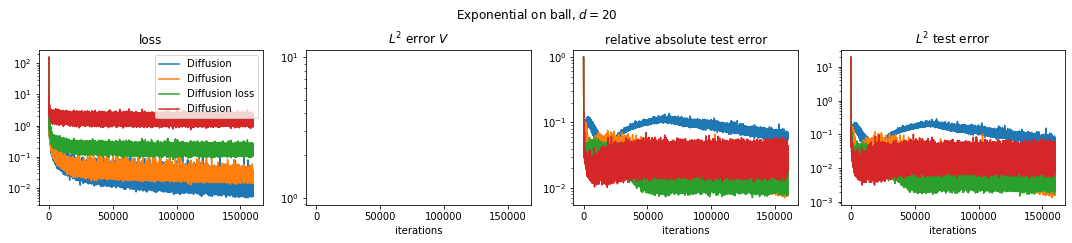

In [31]:
fig = plot_loss_logs_extended('Exponential on ball', models_diffusion)

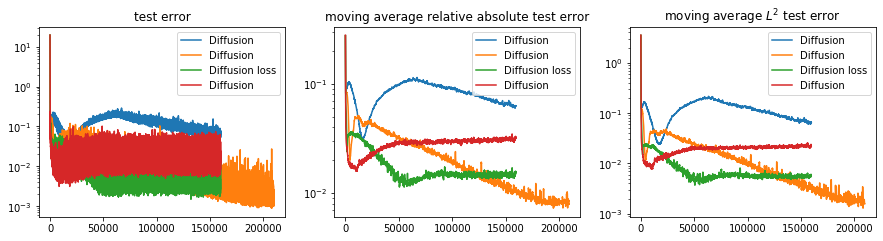

In [36]:
fig = plot_moving_average('Exponential on ball', models_diffusion)

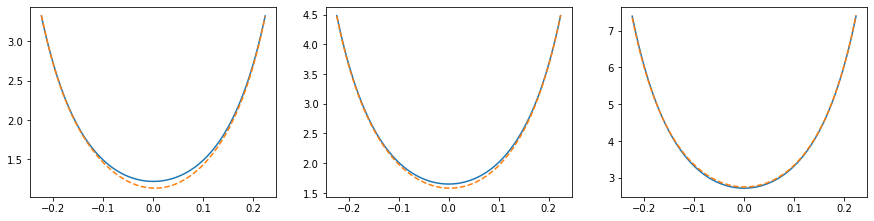

In [37]:
model = models_diffusion[1]

t_1 = 0.2
t_2 = 0.5
t_3 = 1.0

fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))

x_val = pt.linspace(-1 / np.sqrt(d), 1 / np.sqrt(d), 100)

X = pt.autograd.Variable(x_val.unsqueeze(1).repeat(1, model.d), requires_grad=True).to(model.device)

X_t_1 = pt.cat([X, t_1 * pt.ones(100).unsqueeze(1).to(device)], 1)
X_t_2 = pt.cat([X, t_2 * pt.ones(100).unsqueeze(1).to(device)], 1)
X_t_3 = pt.cat([X, t_3 * pt.ones(100).unsqueeze(1).to(device)], 1)

ax[0].plot(x_val.numpy(), model.problem.v_true(x_val.unsqueeze(1).repeat(1, model.d), t_1).numpy())
ax[0].plot(x_val.numpy(), model.V(X_t_1)[:, 0].detach().cpu().numpy(), '--');
ax[1].plot(x_val.numpy(), model.problem.v_true(x_val.unsqueeze(1).repeat(1, model.d), t_2).numpy())
ax[1].plot(x_val.numpy(), model.V(X_t_2)[:, 0].detach().cpu().numpy(), '--');
ax[2].plot(x_val.numpy(), model.problem.v_true(x_val.unsqueeze(1).repeat(1, model.d), t_3).numpy())
ax[2].plot(x_val.numpy(), model.V(X_t_3)[:, 0].detach().cpu().numpy(), '--');

In [11]:
V_ref = np.zeros([100, 100])
V_est = np.zeros([100, 100])

for i, t in enumerate(np.linspace(0, 1, 100)):
    V_ref[:, i] =  model.problem.v_true(x_val.unsqueeze(1).repeat(1, model.d), t).numpy()
    X_t = pt.cat([X, t * pt.ones(100).unsqueeze(1).to(device)], 1)
    V_est[:, i] = model.V(X_t)[:, 0].detach().cpu().numpy()

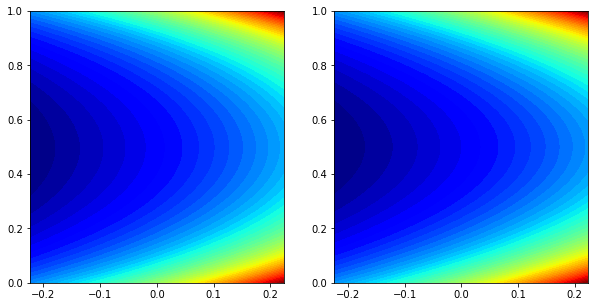

In [12]:
y_1d = np.linspace(0, 1, 100)
x_2d, y_2d = np.meshgrid(x_val, y_1d)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].contourf(x_2d, y_2d, V_est, cmap=cm.jet, levels=np.linspace(np.min(V_est), np.max(V_est), 50));
ax[1].contourf(x_2d, y_2d, V_ref, cmap=cm.jet, levels=np.linspace(np.min(V_ref), np.max(V_ref), 50));

## PINN loss

In [4]:
d = 20
L = 160000
print_every = 1000
N = 25
delta_t = 0.001

seed = 42

problem = ExponentialOnSphereNonlinearParabolic(d=d, T=1.0)

problem.boundary_type = 'Neumann'

models_pinn = [GeneralSolver(problem, 'PINN', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200,
                 K_boundary=50, alpha=[0.1, 1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='PINN', 
                loss_with_stopped=False, K_test_log=10000),
         GeneralSolver(problem, 'PINN', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200,
                 K_boundary=50, alpha=[1.0, 1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='PINN', 
                loss_with_stopped=False, K_test_log=10000),
         GeneralSolver(problem, 'PINN', seed=42, delta_t=delta_t, N=N, lr=0.001, L=L, K=200,
                 K_boundary=50, alpha=[10.0, 1.0, 1.0], adaptive_forward_process=False, detach_forward=True,
                 print_every=print_every, verbose=True, approx_method='Y', sample_center=False, loss_method='PINN', 
                loss_with_stopped=False, K_test_log=10000)]

for model in models_pinn:
    model.V = DenseNet(d + 1, 1, 0.001, arch=[d + 20, d, d, d]).to(device)

In [ ]:
for model in models_pinn:
    model.train()

0 - loss = 6.3466e-01 - v L2 error = 0.0000e+00 - 0.15
1000 - loss = 6.0491e-01 - v L2 error = 0.0000e+00 - 0.44
2000 - loss = 5.9613e-01 - v L2 error = 0.0000e+00 - 0.23
3000 - loss = 5.8458e-01 - v L2 error = 0.0000e+00 - 0.26
4000 - loss = 5.3615e-01 - v L2 error = 0.0000e+00 - 1.27
5000 - loss = 5.5603e-01 - v L2 error = 0.0000e+00 - 1.15
6000 - loss = 5.5561e-01 - v L2 error = 0.0000e+00 - 0.67
7000 - loss = 7.0278e-01 - v L2 error = 0.0000e+00 - 1.15


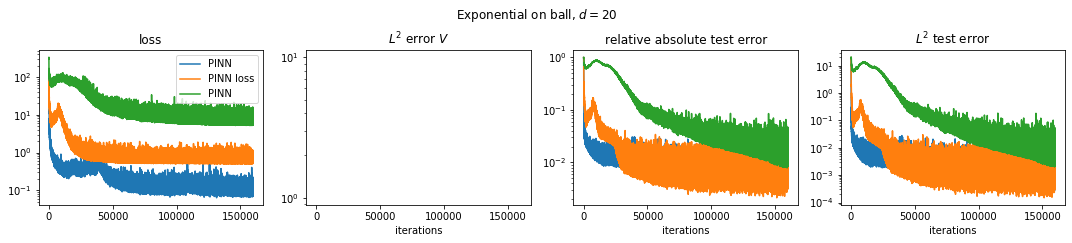

In [33]:
fig = plot_loss_logs_extended('Exponential on ball', models_pinn)

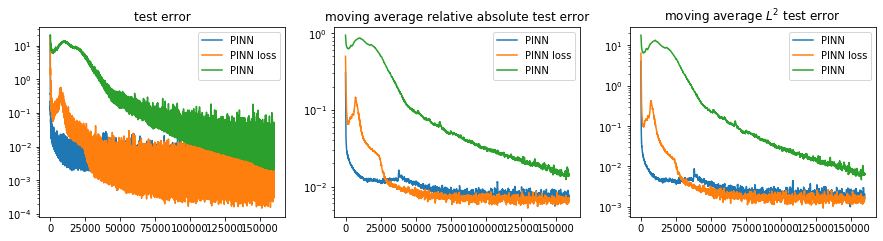

In [34]:
fig = plot_moving_average('Exponential on ball', models_pinn)

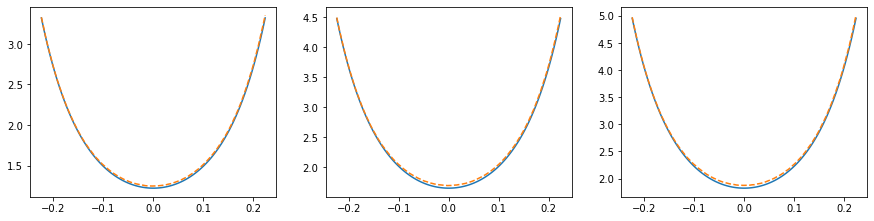

In [40]:
model = models_pinn[1]

t_1 = 0.2
t_2 = 0.5
t_3 = 0.6

fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))

x_val = pt.linspace(-1 / np.sqrt(d), 1 / np.sqrt(d), 100)

X = pt.autograd.Variable(x_val.unsqueeze(1).repeat(1, model.d), requires_grad=True).to(model.device)

X_t_1 = pt.cat([X, t_1 * pt.ones(100).unsqueeze(1).to(device)], 1)
X_t_2 = pt.cat([X, t_2 * pt.ones(100).unsqueeze(1).to(device)], 1)
X_t_3 = pt.cat([X, t_3 * pt.ones(100).unsqueeze(1).to(device)], 1)

ax[0].plot(x_val.numpy(), model.problem.v_true(x_val.unsqueeze(1).repeat(1, model.d), t_1).numpy())
ax[0].plot(x_val.numpy(), model.V(X_t_1)[:, 0].detach().cpu().numpy(), '--');
ax[1].plot(x_val.numpy(), model.problem.v_true(x_val.unsqueeze(1).repeat(1, model.d), t_2).numpy())
ax[1].plot(x_val.numpy(), model.V(X_t_2)[:, 0].detach().cpu().numpy(), '--');
ax[2].plot(x_val.numpy(), model.problem.v_true(x_val.unsqueeze(1).repeat(1, model.d), t_3).numpy())
ax[2].plot(x_val.numpy(), model.V(X_t_3)[:, 0].detach().cpu().numpy(), '--');

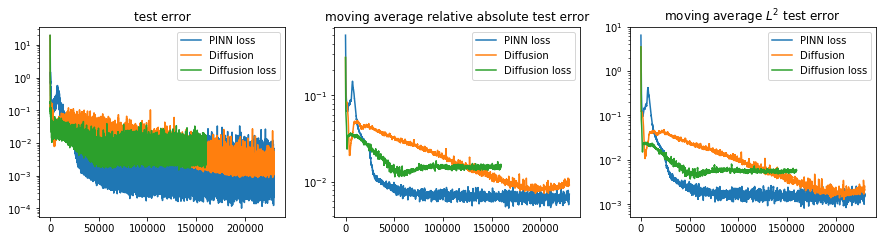

In [47]:
fig = plot_moving_average('Exponential on ball', models_pinn[1:2] + models_diffusion[1:3])

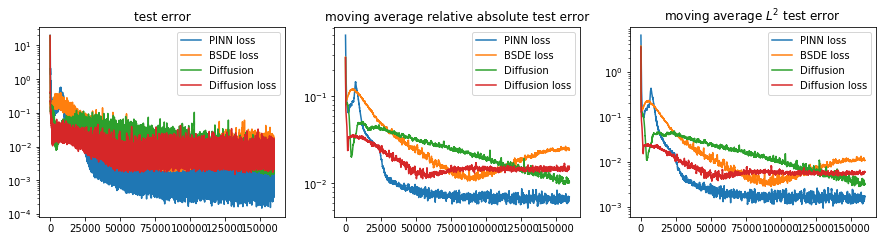

In [25]:
fig = plot_moving_average('Exponential on ball', models_pinn[1:2] + models_diffusion[1:3])

In [17]:
#models_pinn[1].name = 'PINN loss'
#models_diffusion[2].name = 'Diffusion loss'

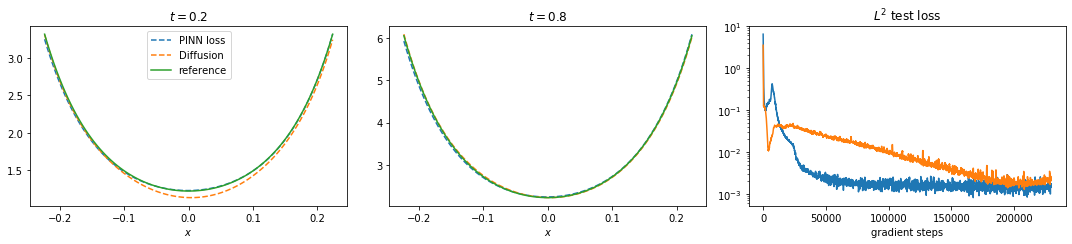

In [49]:
models = models_pinn[1:2] + models_diffusion[1:2] # + models_bsde

moving_span = 400

t_1 = 0.2
t_2 = 0.8
t_3 = 1.0

fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))

x_val = pt.linspace(-1 / np.sqrt(d), 1 / np.sqrt(d), 100)

X = pt.autograd.Variable(x_val.unsqueeze(1).repeat(1, model.d), requires_grad=True).to(model.device)

X_t_1 = pt.cat([X, t_1 * pt.ones(100).unsqueeze(1).to(device)], 1)
X_t_2 = pt.cat([X, t_2 * pt.ones(100).unsqueeze(1).to(device)], 1)
#X_t_3 = pt.cat([X, t_3 * pt.ones(100).unsqueeze(1).to(device)], 1)


#ax[2].plot(x_val.numpy(), model.problem.v_true(x_val.unsqueeze(1).repeat(1, model.d), t_3).numpy())

for model in models:
    ax[0].plot(x_val.numpy(), model.V(X_t_1)[:, 0].detach().cpu().numpy(), '--', label=model.name);
    ax[1].plot(x_val.numpy(), model.V(X_t_2)[:, 0].detach().cpu().numpy(), '--');
    ax[2].plot([np.mean(model.V_test_L2[i:i + moving_span]) for i in range(len(model.V_test_L2) - moving_span)], label=model.name) 
ax[2].set_yscale('log')

ax[0].plot(x_val.numpy(), model.problem.v_true(x_val.unsqueeze(1).repeat(1, model.d), t_1).numpy(), label='reference')
ax[1].plot(x_val.numpy(), model.problem.v_true(x_val.unsqueeze(1).repeat(1, model.d), t_2).numpy())
ax[0].set_title(r'$t = 0.2$')
ax[1].set_title(r'$t = 0.8$')
ax[2].set_title(r'$L^2$ test loss')
ax[0].set_xlabel(r'$x$')
ax[1].set_xlabel(r'$x$')
ax[2].set_xlabel('gradient steps')
ax[0].legend();


fig.tight_layout()

#fig.savefig('img/toy_example_parabolic_neumann_d20_2.pdf')